In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortex"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 512)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 512)

In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [11]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.5min


[CV] .............. C=0.01, gamma=1e-08, score=0.138084, total= 2.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137863, total= 2.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138614, total= 2.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138067, total= 2.8min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137863, total= 2.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137863, total= 2.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138477, total= 2.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  6.8min


[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.337771, total= 4.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138477, total= 4.2min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.335627, total= 4.3min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.337784, total= 4.3min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138614, total= 4.3min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.137863, total= 4.4min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.138067, total= 4.4min
[CV] C

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.0min


[CV] .............. C=0.01, gamma=0.001, score=0.447070, total= 2.8min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.450495, total= 2.8min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.447174, total= 2.9min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.440335, total= 2.9min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.455984, total= 3.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.339604, total= 3.2min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.374876, total= 3.9min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.8min


[CV] ............... C=0.1, gamma=1e-08, score=0.137863, total= 3.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138067, total= 2.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138477, total= 2.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.154455, total= 4.2min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.201871, total= 5.9min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138084, total= 3.0min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.137863, total= 3.0min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 15.2min


[CV] ............... C=0.1, gamma=1e-07, score=0.138477, total= 3.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.01, gamma=10.0, score=0.152826, total= 5.9min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.211045, total= 6.0min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.215628, total= 6.0min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.153127, total= 5.9min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.151381, total= 6.0min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.212376, total= 6.1min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 18.7min


[CV] ............... C=0.1, gamma=1e-06, score=0.138084, total= 3.2min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.809665, total= 1.9min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.820969, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.138067, total= 3.2min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.817822, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.137863, total= 3.2min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.138477, total= 3.1min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 21.5min


[CV] ................ C=0.1, gamma=0.01, score=0.458968, total= 4.6min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.356083, total= 4.2min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.437870, total= 4.5min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.448055, total= 4.6min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.459406, total= 3.2min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.317445, total= 3.8min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.308223, total= 3.8min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 26.8min


[CV] ................. C=0.1, gamma=1.0, score=0.275184, total= 5.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................. C=0.1, gamma=1.0, score=0.259478, total= 5.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................. C=0.1, gamma=0.1, score=0.321958, total= 5.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................. C=0.1, gamma=1.0, score=0.270030, total= 5.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.780835, total= 1.5min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.138477, total= 3.0min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.759232, total= 1.5min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 28.9min


[CV] ............... C=1.0, gamma=1e-06, score=0.364985, total= 2.9min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.369769, total= 2.9min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-07, score=0.138067, total= 4.4min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-07, score=0.137863, total= 4.4min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.888943, total= 1.1min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.884293, total= 1.1min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.372772, total= 3.0min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 32.9min


[CV] ................ C=1.0, gamma=0.01, score=0.644059, total= 3.1min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=0.01, score=0.627027, total= 4.4min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.378338, total= 3.9min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.392574, total= 3.9min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.137863, total= 3.0min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.331204, total= 4.0min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.138067, total= 3.1min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 37.3min


[CV] ................. C=1.0, gamma=1.0, score=0.339109, total= 5.8min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.138477, total= 4.3min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.279173, total= 5.8min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.366585, total= 3.0min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.286489, total= 5.8min
[CV] .............. C=10.0, gamma=1e-06, score=0.781327, total= 1.6min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.758740, total= 1.5min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 38.6min


[CV] .............. C=10.0, gamma=1e-07, score=0.373267, total= 3.1min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.950495, total= 1.2min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.935992, total= 1.6min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.938575, total= 1.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.943294, total= 1.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.939664, total= 1.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.365480, total= 4.2min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 44.8min


[CV] ............. C=100.0, gamma=1e-07, score=0.778600, total= 1.5min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.290927, total= 4.2min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.877893, total=  43.6s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-06, score=0.899110, total=  45.4s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.297230, total= 4.2min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-06, score=0.893564, total=  46.3s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-05, score=0.923833, total=  29.7s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 46.5min


[CV] ............. C=100.0, gamma=1e-08, score=0.370753, total= 4.0min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.938675, total=  31.3s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.364398, total= 4.0min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............... C=10.0, gamma=10.0, score=0.284589, total= 5.9min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............... C=10.0, gamma=10.0, score=0.296314, total= 5.9min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.947525, total=  30.5s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.365480, total= 4.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 52.0min


[CV] ............... C=100.0, gamma=1.0, score=0.330375, total= 4.0min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.894477, total=  45.1s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.899110, total=  45.6s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.759232, total= 2.1min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.892574, total=  46.4s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.778600, total= 2.1min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.284589, total= 4.2min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 58.5min remaining:  3.3min


[CV] .............. C=1000.0, gamma=0.1, score=0.386746, total= 3.4min
[CV] .............. C=1000.0, gamma=0.1, score=0.377154, total= 3.5min
[CV] .............. C=1000.0, gamma=1.0, score=0.331364, total= 3.5min
[CV] ............. C=1000.0, gamma=0.01, score=0.664851, total= 4.0min
[CV] ............. C=1000.0, gamma=0.01, score=0.638477, total= 3.8min
[CV] ............. C=1000.0, gamma=10.0, score=0.297230, total= 3.4min
[CV] ............. C=1000.0, gamma=10.0, score=0.284589, total= 3.8min
[CV] ............. C=1000.0, gamma=10.0, score=0.301485, total= 3.4min
[CV] .............. C=1000.0, gamma=0.1, score=0.379684, total= 4.6min
[CV] .............. C=1000.0, gamma=1.0, score=0.338575, total= 4.6min
[CV] .............. C=1000.0, gamma=0.1, score=0.402970, total= 4.6min
[CV] .............. C=1000.0, gamma=1.0, score=0.329882, total= 4.5min
[CV] .............. C=1000.0, gamma=1.0, score=0.349505, total= 4.5min
[CV] .............. C=1000.0, gamma=1.0, score=0.334817, total= 4.6min
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 60.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
top_model.cv_results_

{'mean_fit_time': array([ 142.03704362,  171.26192679,  160.78794823,  225.39443245,
         208.52699919,  149.2446146 ,  208.62276382,  305.34440222,
         320.58315601,  282.07300434,  151.50718789,  153.92723227,
         163.106144  ,  175.670679  ,   90.12373505,   94.66629939,
         216.32838531,  249.39570484,  270.28308077,  256.91734676,
         177.1982306 ,  199.47244139,  148.63167167,   71.55994   ,
          47.72661414,   56.64184432,  181.62921796,  258.08898416,
         288.74953403,  259.32446556,  182.3734262 ,  167.10419102,
          72.25469437,   39.47654505,   27.32261825,   74.76199899,
         181.86306591,  213.80203738,  293.64643798,  287.07708044,
         194.33784924,   71.06025519,   33.87833281,   19.71275158,
          20.7125814 ,   65.27693558,  166.43706775,  268.87892594,
         292.12092814,  269.17095518,   89.02273564,   31.17965655,
          20.74399042,   23.55200596,   23.25759783,   56.78840466,
         178.5148252 ,  214.400

In [13]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00028, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00028, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00028, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.13822, std: 0.00028, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.33781, std: 0.00128, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.44820, std: 0.00510, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.35852, std: 0.00939, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.21014, std: 0.00457, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.19959, std: 0.00347, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.15371, std: 0.00182, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.13822, std: 0.00028, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00028, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00028, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [14]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 0.0001} - score: 0.9419


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


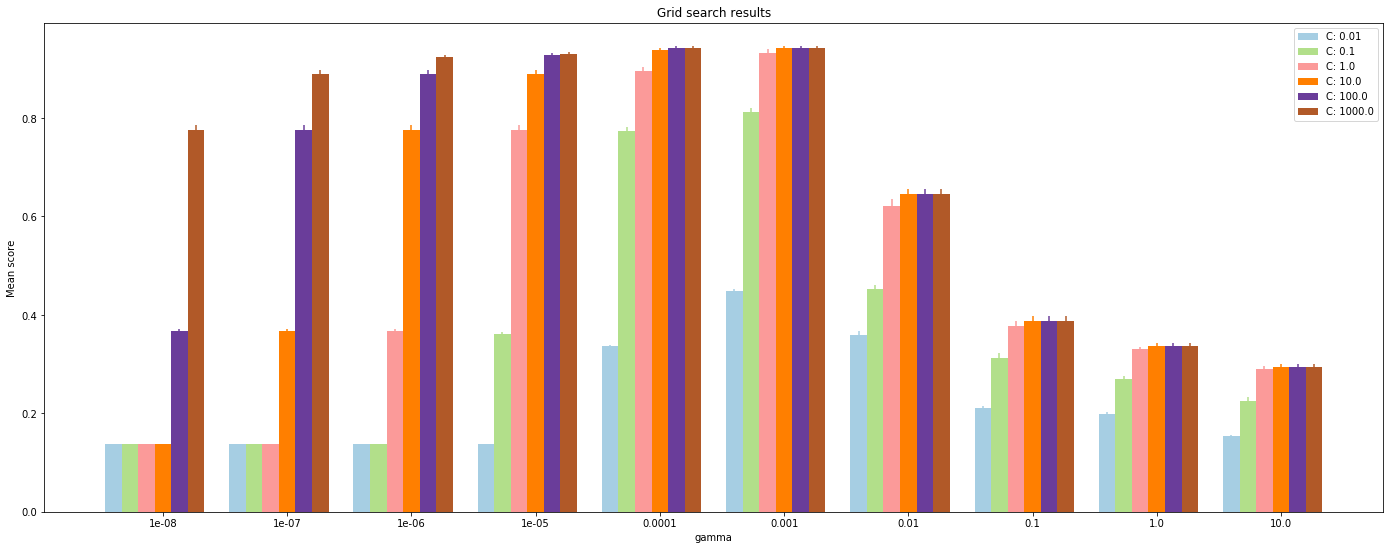

In [15]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()